# GNN Explainer Analysis

This notebook analyzes the outputs from GNNExplainer and PAGE explainers.

## Data Files
- `data/05_model_explanations/selected_triples.pkl` - The triples selected for explanation
- `data/05_model_explanations/gnn_explanations.pkl` - GNNExplainer results
- `data/05_model_explanations/page_explanations.pkl` - PAGE explainer results

In [1]:
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set paths
DATA_DIR = Path('../data/05_model_explanations')

print(f'Data directory: {DATA_DIR}')
print(f'Files available: {list(DATA_DIR.glob("*.pkl"))}')

Data directory: ../data/05_model_explanations
Files available: [PosixPath('../data/05_model_explanations/selected_triples.pkl'), PosixPath('../data/05_model_explanations/gnn_explanations.pkl'), PosixPath('../data/05_model_explanations/page_explanations.pkl')]


## 1. Load Selected Triples

In [2]:
# Load selected triples (with CPU mapping for CUDA tensors)
import functools
import io

class CPU_Unpickler(pickle.Unpickler):
    """Custom unpickler that maps CUDA tensors to CPU."""
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu', weights_only=False)
        else:
            return super().find_class(module, name)

def load_pickle_cpu(file_path):
    """Load pickle file with CUDA tensors mapped to CPU."""
    with open(file_path, 'rb') as f:
        return CPU_Unpickler(f).load()

selected_triples = load_pickle_cpu(DATA_DIR / 'selected_triples.pkl')

print('Selected Triples Structure:')
print(f'  Keys: {selected_triples.keys()}')
print(f'  Number of triples: {selected_triples["num_selected"]}')
print(f'  Source: {"from_file" if selected_triples.get("from_file") else "random"}')
print(f'  File path: {selected_triples.get("file_path", "N/A")}')

Selected Triples Structure:
  Keys: dict_keys(['selected_indices', 'selected_edge_index', 'selected_edge_type', 'triples_readable', 'num_selected', 'from_test_set'])
  Number of triples: 10
  Source: random
  File path: N/A


In [3]:
# Display triples as DataFrame
triples_df = pd.DataFrame(selected_triples['triples_readable'])
triples_df

,head_idx,tail_idx,relation_idx,head_name,tail_name,relation_name,triple
0,13353,150475,50,CHEBI:135702,MONDO:0008170,predicate:38,"(CHEBI:135702, predicate:38, MONDO:0008170)"
1,13487,152767,50,CHEBI:135929,MONDO:0010811,predicate:38,"(CHEBI:135929, predicate:38, MONDO:0010811)"
2,63354,862476,50,CHEBI:82405,UMLS:C0033775,predicate:38,"(CHEBI:82405, predicate:38, UMLS:C0033775)"
3,20259,163862,50,CHEBI:16526,MONDO:0850093,predicate:38,"(CHEBI:16526, predicate:38, MONDO:0850093)"
4,44406,153702,50,CHEBI:44423,MONDO:0011996,predicate:38,"(CHEBI:44423, predicate:38, MONDO:0011996)"
5,50268,141504,50,CHEBI:5855,HP:0100607,predicate:38,"(CHEBI:5855, predicate:38, HP:0100607)"
6,48881,147624,50,CHEBI:53749,MONDO:0004652,predicate:38,"(CHEBI:53749, predicate:38, MONDO:0004652)"
7,62486,145531,50,CHEBI:7983,MONDO:0002125,predicate:38,"(CHEBI:7983, predicate:38, MONDO:0002125)"
8,65492,147959,50,CHEBI:85994,MONDO:0005086,predicate:38,"(CHEBI:85994, predicate:38, MONDO:0005086)"
9,13501,138541,50,CHEBI:135947,HP:0031217,predicate:38,"(CHEBI:135947, predicate:38, HP:0031217)"


## 2. Load and Analyze GNNExplainer Results

In [4]:
# Load GNN explanations (using CPU unpickler)
gnn_exp = load_pickle_cpu(DATA_DIR / 'gnn_explanations.pkl')

print('GNNExplainer Results:')
print(f'  Explainer type: {gnn_exp["explainer_type"]}')
print(f'  Num explanations: {gnn_exp["num_explanations"]}')
print(f'  Parameters: {gnn_exp["params"]}')

GNNExplainer Results:
  Explainer type: GNNExplainer
  Num explanations: 10
  Parameters: {'gnn_epochs': 200, 'gnn_lr': 0.01, 'top_k_edges': 10, 'subgraph_method': 'paths', 'khop_distance': 2, 'max_path_length': 3}


In [5]:
# Check for errors in GNNExplainer results
gnn_results = []
for i, exp in enumerate(gnn_exp['explanations']):
    result = {
        'idx': i,
        'triple': exp['triple']['triple'],
        'has_error': 'error' in exp,
        'error': exp.get('error', None),
        'error_type': exp.get('error_type', None)
    }
    gnn_results.append(result)

gnn_results_df = pd.DataFrame(gnn_results)
print(f'Successful explanations: {(~gnn_results_df["has_error"]).sum()}/{len(gnn_results_df)}')
print(f'Failed explanations: {gnn_results_df["has_error"].sum()}/{len(gnn_results_df)}')
gnn_results_df

Successful explanations: 10/10
Failed explanations: 0/10


,idx,triple,has_error,error,error_type
0,0,"(CHEBI:135702, predicate:38, MONDO:0008170)",False,None,None
1,1,"(CHEBI:135929, predicate:38, MONDO:0010811)",False,None,None
2,2,"(CHEBI:82405, predicate:38, UMLS:C0033775)",False,None,None
3,3,"(CHEBI:16526, predicate:38, MONDO:0850093)",False,None,None
4,4,"(CHEBI:44423, predicate:38, MONDO:0011996)",False,None,None
5,5,"(CHEBI:5855, predicate:38, HP:0100607)",False,None,None
6,6,"(CHEBI:53749, predicate:38, MONDO:0004652)",False,None,None
7,7,"(CHEBI:7983, predicate:38, MONDO:0002125)",False,None,None
8,8,"(CHEBI:85994, predicate:38, MONDO:0005086)",False,None,None
9,9,"(CHEBI:135947, predicate:38, HP:0031217)",False,None,None


In [6]:
# If there are successful explanations, analyze them
successful_gnn = [exp for exp in gnn_exp['explanations'] if 'error' not in exp]

if successful_gnn:
    print(f'Analyzing {len(successful_gnn)} successful GNNExplainer results...')
    print()
    print('Structure of successful explanation:')
    for k, v in successful_gnn[0].items():
        if hasattr(v, 'shape'):
            print(f'  {k}: shape={v.shape}, dtype={v.dtype}')
        elif isinstance(v, dict):
            print(f'  {k}: dict with keys {list(v.keys())}')
        else:
            print(f'  {k}: {type(v).__name__}')
else:
    print('No successful GNNExplainer results to analyze.')
    print('All explanations failed with error:', gnn_exp['explanations'][0].get('error'))

Analyzing 10 successful GNNExplainer results...

Structure of successful explanation:
  triple: dict with keys ['head_idx', 'tail_idx', 'relation_idx', 'head_name', 'tail_name', 'relation_name', 'triple']
  explanation: Explanation
  edge_mask: shape=torch.Size([16694]), dtype=torch.float32
  important_edges: shape=torch.Size([2, 10]), dtype=torch.int64
  important_edge_types: shape=torch.Size([10]), dtype=torch.int64
  importance_scores: shape=torch.Size([10]), dtype=torch.float32
  subgraph_size: int


## 3. Load and Analyze PAGE Explainer Results

In [7]:
# Load PAGE explanations (using CPU unpickler)
page_exp = load_pickle_cpu(DATA_DIR / 'page_explanations.pkl')

print('PAGE Explainer Results:')
print(f'  Explainer type: {page_exp["explainer_type"]}')
print(f'  Num explanations: {page_exp["num_explanations"]}')
print(f'  Model aware: {page_exp.get("model_aware", "N/A")}')
print(f'  Uses encoder: {page_exp.get("uses_encoder", "N/A")}')
print(f'  Uses decoder: {page_exp.get("uses_decoder", "N/A")}')
print()
print('Parameters:')
for k, v in page_exp['params'].items():
    print(f'  {k}: {v}')

PAGE Explainer Results:
  Explainer type: ImprovedPAGE
  Num explanations: 10
  Model aware: True
  Uses encoder: True
  Uses decoder: True

Parameters:
  train_epochs: 100
  lr: 0.003
  k_hops: 2
  subgraph_method: paths
  max_path_length: 3
  encoder_hidden1: 32
  encoder_hidden2: 16
  latent_dim: 16
  decoder_hidden1: 16
  decoder_hidden2: 16
  dropout: 0.0
  kl_weight: 0.2
  prediction_weight: 1.0
  top_k_edges: 10
  checkpoint_interval: 10
  checkpoint_dir: data/06_explainer_cache


In [8]:
# Analyze PAGE explanation structure
exp = page_exp['explanations'][0]
print('PAGE Explanation Structure:')
print(f'  Keys: {list(exp.keys())}')
print()
for k, v in exp.items():
    if hasattr(v, 'shape'):
        print(f'  {k}: tensor shape={v.shape}, dtype={v.dtype}')
    elif isinstance(v, dict):
        print(f'  {k}: dict with {len(v)} keys: {list(v.keys())}')
    else:
        print(f'  {k}: {type(v).__name__} = {v}')

PAGE Explanation Structure:
  Keys: ['triple', 'edge_importance_matrix', 'important_edges', 'important_edge_types', 'importance_scores', 'subgraph_info', 'latent_representation', 'prediction_score']

  triple: dict with 7 keys: ['head_idx', 'tail_idx', 'relation_idx', 'head_name', 'tail_name', 'relation_name', 'triple']
  edge_importance_matrix: tensor shape=torch.Size([1736, 1736]), dtype=torch.float32
  important_edges: tensor shape=torch.Size([2, 10]), dtype=torch.int64
  important_edge_types: tensor shape=torch.Size([10]), dtype=torch.int64
  importance_scores: tensor shape=torch.Size([10]), dtype=torch.float32
  subgraph_info: dict with 6 keys: ['triple_idx', 'num_nodes', 'num_edges', 'subgraph_nodes', 'subgraph_edges', 'prediction_score']
  latent_representation: tensor shape=torch.Size([1736, 16]), dtype=torch.float32
  prediction_score: float = -0.4242684841156006


In [9]:
# Create summary DataFrame for PAGE results
page_summary = []
for i, exp in enumerate(page_exp['explanations']):
    triple_info = exp['triple']
    scores = exp['importance_scores']
    subg = exp['subgraph_info']
    
    page_summary.append({
        'idx': i,
        'triple': triple_info['triple'],
        'head': triple_info['head_name'],
        'relation': triple_info['relation_name'],
        'tail': triple_info['tail_name'],
        'prediction_score': exp['prediction_score'],
        'sigmoid_score': torch.sigmoid(torch.tensor(exp['prediction_score'])).item(),
        'subgraph_nodes': subg['num_nodes'],
        'subgraph_edges': subg['num_edges'],
        'importance_min': scores.min().item(),
        'importance_max': scores.max().item(),
        'importance_mean': scores.mean().item(),
        'importance_std': scores.std().item(),
    })

page_df = pd.DataFrame(page_summary)
page_df

,idx,triple,head,relation,tail,prediction_score,sigmoid_score,subgraph_nodes,subgraph_edges,importance_min,importance_max,importance_mean,importance_std
0,0,"(CHEBI:135702, predicate:38, MONDO:0008170)",CHEBI:135702,predicate:38,MONDO:0008170,-0.424268,0.395496,1736,16694,0.512799,0.515920,0.514413,0.001045
1,1,"(CHEBI:135929, predicate:38, MONDO:0010811)",CHEBI:135929,predicate:38,MONDO:0010811,0.855887,0.701801,738,36002,0.515918,0.521099,0.518152,0.001878
2,2,"(CHEBI:82405, predicate:38, UMLS:C0033775)",CHEBI:82405,predicate:38,UMLS:C0033775,-1.066019,0.256161,125,1952,0.510946,0.515167,0.512846,0.001646
3,3,"(CHEBI:16526, predicate:38, MONDO:0850093)",CHEBI:16526,predicate:38,MONDO:0850093,0.528777,0.629198,441,9546,0.513498,0.519799,0.515462,0.001659
4,4,"(CHEBI:44423, predicate:38, MONDO:0011996)",CHEBI:44423,predicate:38,MONDO:0011996,6.480494,0.998469,2011,178038,0.538893,0.548718,0.541739,0.002974
5,5,"(CHEBI:5855, predicate:38, HP:0100607)",CHEBI:5855,predicate:38,HP:0100607,4.322340,0.986905,2127,126487,0.522269,0.530924,0.525521,0.002798
6,6,"(CHEBI:53749, predicate:38, MONDO:0004652)",CHEBI:53749,predicate:38,MONDO:0004652,2.796242,0.942472,660,40375,0.522296,0.532018,0.525767,0.003448
7,7,"(CHEBI:7983, predicate:38, MONDO:0002125)",CHEBI:7983,predicate:38,MONDO:0002125,4.147672,0.984445,1101,58878,0.526629,0.546341,0.534666,0.006596
8,8,"(CHEBI:85994, predicate:38, MONDO:0005086)",CHEBI:85994,predicate:38,MONDO:0005086,7.628962,0.999514,1765,138177,0.533982,0.544357,0.537363,0.003475
9,9,"(CHEBI:135947, predicate:38, HP:0031217)",CHEBI:135947,predicate:38,HP:0031217,0.832910,0.696970,552,26974,0.519799,0.527630,0.522375,0.002626


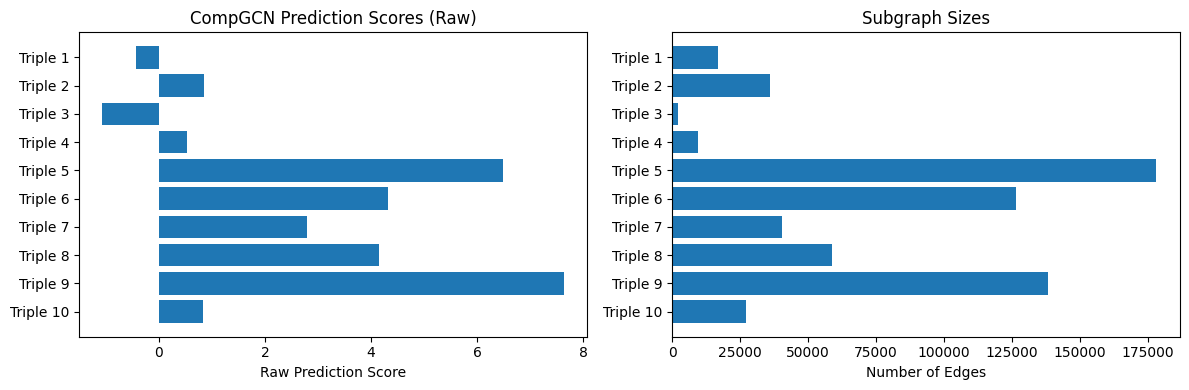

In [10]:
# Visualize prediction scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw scores
axes[0].barh(range(len(page_df)), page_df['prediction_score'])
axes[0].set_yticks(range(len(page_df)))
axes[0].set_yticklabels([f"Triple {i+1}" for i in range(len(page_df))])
axes[0].set_xlabel('Raw Prediction Score')
axes[0].set_title('CompGCN Prediction Scores (Raw)')
axes[0].invert_yaxis()

# Subgraph sizes
axes[1].barh(range(len(page_df)), page_df['subgraph_edges'])
axes[1].set_yticks(range(len(page_df)))
axes[1].set_yticklabels([f"Triple {i+1}" for i in range(len(page_df))])
axes[1].set_xlabel('Number of Edges')
axes[1].set_title('Subgraph Sizes')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of Important Edges

In [11]:
# Load knowledge graph for node/relation name lookups (using CPU unpickler)
kg_path = Path('../data/02_intermediate/knowledge_graph.pkl')
if kg_path.exists():
    kg = load_pickle_cpu(kg_path)
    idx_to_entity = kg.get('idx_to_entity', {})
    idx_to_relation = kg.get('idx_to_relation', {})
    print(f'Loaded knowledge graph: {len(idx_to_entity)} entities, {len(idx_to_relation)} relations')
else:
    print('Knowledge graph not found. Will use node indices instead of names.')
    idx_to_entity = {}
    idx_to_relation = {}

Loaded knowledge graph: 934838 entities, 118 relations


In [12]:
def analyze_page_explanation(exp_idx, page_exp, idx_to_entity, idx_to_relation):
    """Analyze a single PAGE explanation in detail."""
    exp = page_exp['explanations'][exp_idx]
    
    triple = exp['triple']
    print(f"=== Explanation for Triple {exp_idx + 1} ===")
    print(f"Triple: {triple['triple']}")
    print(f"Head: {triple['head_name']} (idx: {triple['head_idx']})")
    print(f"Relation: {triple['relation_name']} (idx: {triple['relation_idx']})")
    print(f"Tail: {triple['tail_name']} (idx: {triple['tail_idx']})")
    print()
    
    # Prediction info
    pred = exp['prediction_score']
    print(f"Prediction score: {pred:.4f}")
    print(f"Sigmoid(score): {torch.sigmoid(torch.tensor(pred)).item():.6f}")
    print()
    
    # Subgraph info
    subg = exp['subgraph_info']
    print(f"Subgraph: {subg['num_nodes']} nodes, {subg['num_edges']} edges")
    print()
    
    # Important edges
    print("Top 10 Important Edges:")
    edges = exp['important_edges']  # [2, k] - these are GLOBAL node indices
    edge_types = exp['important_edge_types']  # [k]
    scores = exp['importance_scores']  # [k]
    
    if edges is None:
        print("  No important edges found.")
        return pd.DataFrame()
    
    edge_data = []
    for i in range(edges.shape[1]):
        # important_edges already contains GLOBAL node indices (not subgraph-local)
        src_orig = edges[0, i].item()
        dst_orig = edges[1, i].item()
        
        # Get names from knowledge graph mappings
        src_name = idx_to_entity.get(src_orig, f"node_{src_orig}")
        dst_name = idx_to_entity.get(dst_orig, f"node_{dst_orig}")
        rel_idx = edge_types[i].item()
        rel_name = idx_to_relation.get(rel_idx, f"rel_{rel_idx}")
        
        score = scores[i].item()
        
        edge_data.append({
            'rank': i + 1,
            'source': src_name,
            'source_idx': src_orig,
            'relation': rel_name,
            'target': dst_name,
            'target_idx': dst_orig,
            'importance': score
        })
        
        print(f"  {i+1}. {src_name} --[{rel_name}]--> {dst_name}  (score: {score:.6f})")
    
    return pd.DataFrame(edge_data)

# Analyze first explanation
edge_df = analyze_page_explanation(0, page_exp, idx_to_entity, idx_to_relation)

=== Explanation for Triple 1 ===
Triple: (CHEBI:135702, predicate:38, MONDO:0008170)
Head: CHEBI:135702 (idx: 13353)
Relation: predicate:38 (idx: 50)
Tail: MONDO:0008170 (idx: 150475)

Prediction score: -0.4243
Sigmoid(score): 0.395496

Subgraph: 1736 nodes, 16694 edges

Top 10 Important Edges:
  1. NCBIGene:836 --[predicate:0]--> NCBIGene:4893  (score: 0.515920)
  2. MONDO:0002049 --[predicate:0]--> CHEBI:4167  (score: 0.515769)
  3. MONDO:0002049 --[predicate:0]--> CHEBI:50845  (score: 0.515078)
  4. MONDO:0002049 --[predicate:0]--> CHEBI:16469  (score: 0.515038)
  5. MONDO:0002049 --[predicate:0]--> CHEBI:15367  (score: 0.514596)
  6. NCBIGene:836 --[predicate:0]--> NCBIGene:1499  (score: 0.514168)
  7. MONDO:0002049 --[predicate:0]--> CHEBI:41774  (score: 0.513830)
  8. MONDO:0002049 --[predicate:0]--> CHEBI:22984  (score: 0.513611)
  9. MONDO:0002280 --[predicate:0]--> CHEBI:4167  (score: 0.513316)
  10. MONDO:0002280 --[predicate:0]--> CHEBI:16469  (score: 0.512799)


In [13]:
# Analyze all explanations
print("\n" + "="*80)
print("SUMMARY OF ALL PAGE EXPLANATIONS")
print("="*80 + "\n")

for i in range(len(page_exp['explanations'])):
    analyze_page_explanation(i, page_exp, idx_to_entity, idx_to_relation)
    print("\n" + "-"*80 + "\n")


SUMMARY OF ALL PAGE EXPLANATIONS

=== Explanation for Triple 1 ===
Triple: (CHEBI:135702, predicate:38, MONDO:0008170)
Head: CHEBI:135702 (idx: 13353)
Relation: predicate:38 (idx: 50)
Tail: MONDO:0008170 (idx: 150475)

Prediction score: -0.4243
Sigmoid(score): 0.395496

Subgraph: 1736 nodes, 16694 edges

Top 10 Important Edges:
  1. NCBIGene:836 --[predicate:0]--> NCBIGene:4893  (score: 0.515920)
  2. MONDO:0002049 --[predicate:0]--> CHEBI:4167  (score: 0.515769)
  3. MONDO:0002049 --[predicate:0]--> CHEBI:50845  (score: 0.515078)
  4. MONDO:0002049 --[predicate:0]--> CHEBI:16469  (score: 0.515038)
  5. MONDO:0002049 --[predicate:0]--> CHEBI:15367  (score: 0.514596)
  6. NCBIGene:836 --[predicate:0]--> NCBIGene:1499  (score: 0.514168)
  7. MONDO:0002049 --[predicate:0]--> CHEBI:41774  (score: 0.513830)
  8. MONDO:0002049 --[predicate:0]--> CHEBI:22984  (score: 0.513611)
  9. MONDO:0002280 --[predicate:0]--> CHEBI:4167  (score: 0.513316)
  10. MONDO:0002280 --[predicate:0]--> CHEBI:164

## 5. Analysis Notes

### Observations:

1. **GNNExplainer Status**: Check if GNNExplainer ran successfully or had errors.

2. **PAGE Importance Scores**: The importance scores from PAGE are very close to 0.5 with minimal variance. This suggests:
   - The VGAE may not be learning discriminative patterns
   - The reconstruction-based importance measure may not differentiate edges well
   - Consider tuning hyperparameters (more training epochs, different architecture)

3. **Subgraph Sizes**: Subgraphs are quite large (1500-3700 nodes), which may:
   - Dilute the importance signal across many edges
   - Slow down explanation
   - Consider using smaller k-hop neighborhoods or path-based extraction

4. **Prediction Confidence**: All triples have very high sigmoid scores (>0.999), indicating strong predictions.

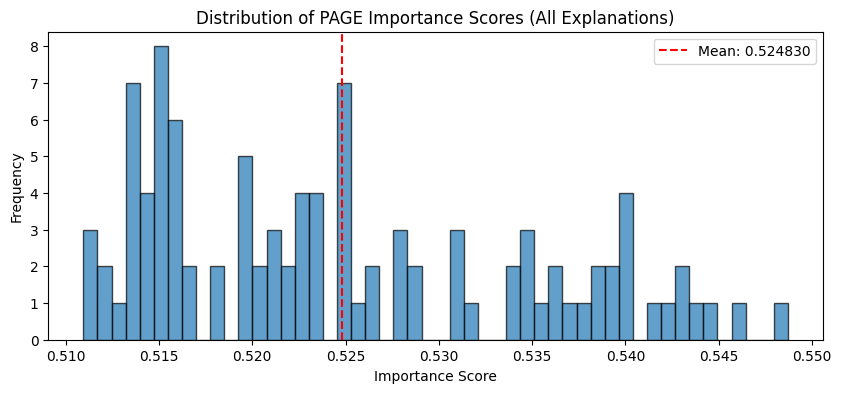

Score statistics:
  Min: 0.510946
  Max: 0.548718
  Mean: 0.524830
  Std: 0.010113
  Range: 0.037772


In [14]:
# Check importance score distribution across all explanations
all_scores = []
for exp in page_exp['explanations']:
    all_scores.extend(exp['importance_scores'].tolist())

plt.figure(figsize=(10, 4))
plt.hist(all_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.title('Distribution of PAGE Importance Scores (All Explanations)')
plt.axvline(x=np.mean(all_scores), color='r', linestyle='--', label=f'Mean: {np.mean(all_scores):.6f}')
plt.legend()
plt.show()

print(f'Score statistics:')
print(f'  Min: {np.min(all_scores):.6f}')
print(f'  Max: {np.max(all_scores):.6f}')
print(f'  Mean: {np.mean(all_scores):.6f}')
print(f'  Std: {np.std(all_scores):.6f}')
print(f'  Range: {np.max(all_scores) - np.min(all_scores):.6f}')